In [45]:
import obspy
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime
import obspy.signal.trigger
from scatseisnet import ScatteringNetwork
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import dates as mdates
import sklearn.decomposition
from sklearn.decomposition import FastICA, PCA
from sklearn.cluster import KMeans, DBSCAN
import umap
from tqdm.auto import tqdm
from pathlib import Path
import pandas as pd
import datetime

In [12]:
def load_lunar(base_dir: Path):
    print("> Loading lunar")
    cat_file = (
        base_dir / "data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv"
    )
    cat = pd.read_csv(cat_file)
    # for convenient access
    cat["arrival_time"] = pd.to_datetime(cat["time_abs(%Y-%m-%dT%H:%M:%S.%f)"])
    cat["arrival_time_rel"] = cat["time_rel(sec)"]

    train_dir = base_dir / "data/lunar/training/data/"
    test_dir = base_dir / "data/lunar/test/data/"

    # get from df so we can match with arrival times
    train_filenames = [train_dir / f"S12_GradeA/{x}.mseed" for x in cat.filename]
    test_filenames = list(test_dir.rglob("*.mseed"))

    print("training data: ", len(list(train_dir.rglob("*.mseed"))))
    print("test data: ", len(test_filenames))

    for i, f in enumerate(train_filenames):
        if "evid00029" in str(f):
            train_filenames[i] = Path(
                "../data/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR02_evid00029.mseed"
            )
    train_streams = []
    for f in train_filenames:
        try:
            train_streams.append(obspy.read(f))
        except Exception as e:
            print(f"Error reading file {f}: {e}")

    test_streams = []
    for f in test_filenames:
        try:
            test_streams.append(obspy.read(f))
        except Exception as e:
            print(f"Error reading file {f}: {e}")
    arr_times = cat["arrival_time_rel"].to_numpy()
    return train_streams, arr_times, test_streams, train_filenames, test_filenames


def load_martian(base_dir: Path):
    print("> Loading martian")
    base_dir = Path("../data/space_apps_2024_seismic_detection")
    cat_file = (
        base_dir / "data/mars/training/catalogs/Mars_InSight_training_catalog_final.csv"
    )
    cat = pd.read_csv(cat_file)
    # for convenient access
    cat["arrival_time"] = pd.to_datetime(cat["time_abs(%Y-%m-%dT%H:%M:%S.%f)"])
    cat["arrival_time_rel"] = cat["time_rel(sec)"]
    train_dir = base_dir / "data/mars/training/data/"
    test_dir = base_dir / "data/mars/test/data/"

    # get from df so we can match with arrival times
    train_filenames = [train_dir / f"{x[:-4]}.mseed" for x in cat.filename]
    test_filenames = list(test_dir.rglob("*.mseed"))

    print("training data: ", len(list(train_dir.rglob("*.mseed"))))
    print("test data: ", len(test_filenames))

    train_streams = []
    for f in train_filenames:
        try:
            train_streams.append(obspy.read(f))
        except Exception as e:
            print(f"Error reading file {f}: {e}")

    test_streams = []
    for f in test_filenames:
        try:
            test_streams.append(obspy.read(f))
        except Exception as e:
            print(f"Error reading file {f}: {e}")
    arr_times = cat["arrival_time_rel"].to_numpy()
    return train_streams, arr_times, test_streams, train_filenames, test_filenames


base_dir = Path("../data/space_apps_2024_seismic_detection")
# X_train, y_train, X_test, train_filenames, test_filenames = load_lunar(base_dir)
X_train, y_train, X_test, train_filenames, test_filenames = load_martian(base_dir)

> Loading martian
training data:  2
test data:  9


# Visualise


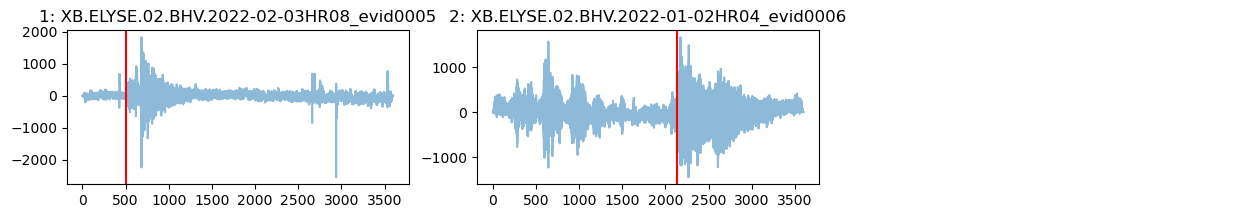

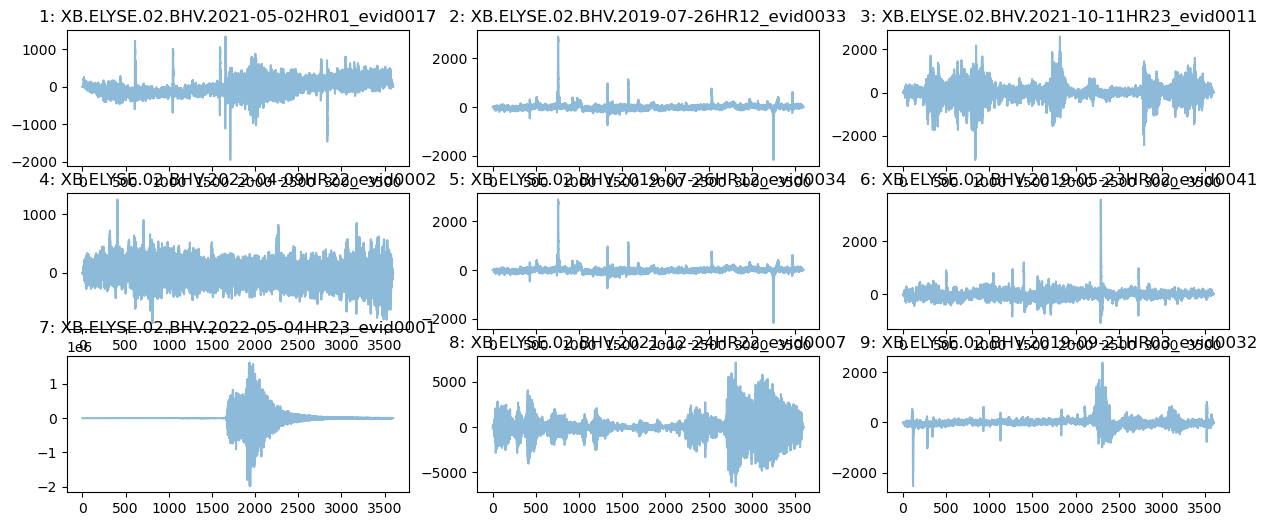

In [13]:
nrows = (len(X_train) + 2) // 3
fig, axs = plt.subplots(nrows, 3, figsize=(15, 2 * nrows))
axs = axs.flatten()

for i, stream in enumerate(X_train):
    x, y = stream[0].times(), stream[0].data

    axs[i].plot(x, y, alpha=0.5)
    axs[i].axvline(x=y_train[i], c="red")
    axs[i].set_title(f"{i+1}: {train_filenames[i].stem}")
for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.show()

nrows = (len(X_test) + 2) // 3
fig, axs = plt.subplots(nrows, 3, figsize=(15, 2 * nrows))
axs = axs.flatten()

for i, stream in enumerate(X_test):
    x, y = stream[0].times(), stream[0].data
    axs[i].plot(x, y, alpha=0.5)
    axs[i].set_title(f"{i+1}: {test_filenames[i].stem}")
for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.show()


# STA/LTA


In [36]:
stream = X_train[1]
out = obspy.signal.trigger.classic_sta_lta(
    stream[0].data,
    nsta=120 * stream[0].stats.sampling_rate,
    nlta=600 * stream[0].stats.sampling_rate,
)


In [40]:
trg_on = 3  # above this is an event
trg_off = 1.5
t = obspy.signal.trigger.trigger_onset(out, trg_on, trg_off)
t

array([[43504, 48335]])

In [60]:
stream[0].times()[t[0, 0]]

2175.2

In [66]:
# v = 0 + datetime.timedelta(seconds=stream[0].times()[t[0, 0]])
v = seconds = stream[0].times()[t[0, 0]]

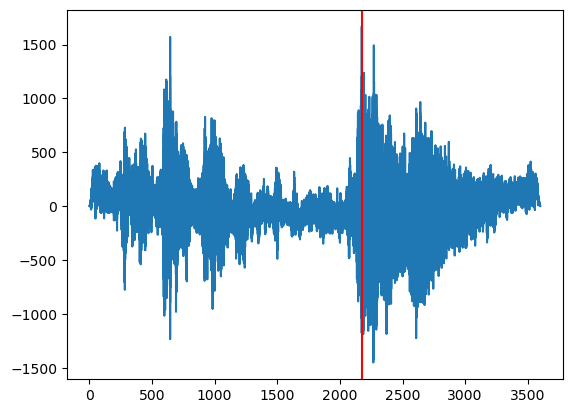

In [68]:
plt.plot(stream[0].times(), stream[0].data)
plt.axvline(v, c="r")

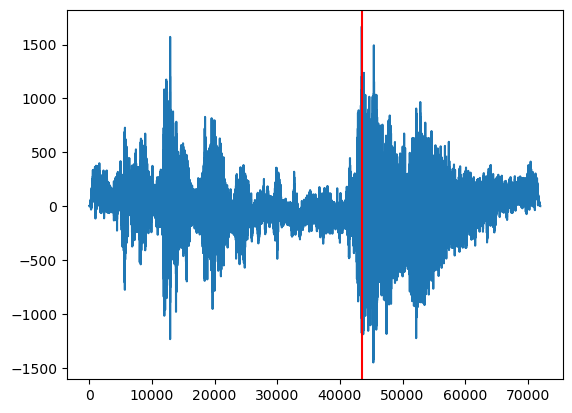

In [41]:
plt.plot(stream[0].data)
plt.axvline(t[0, 0], c="r")

In [72]:
def make_stalta_prediction(stream, sta_len=120, lta_len=600, trg_on=3):
    out = obspy.signal.trigger.classic_sta_lta(
        stream[0].data,
        nsta=sta_len * stream[0].stats.sampling_rate,
        nlta=lta_len * stream[0].stats.sampling_rate,
    )
    t = obspy.signal.trigger.trigger_onset(out, trg_on, 1)
    assert len(t) > 0
    arr_time = stream[0].times()[t[0, 0]]
    return arr_time, out


yhat_train = []
for stream in X_train:
    try:
        result, _ = make_stalta_prediction(stream)
        yhat_train.append(result)
    except Exception:
        yhat_train.append(float("nan"))
yhat_train = np.array(yhat_train)

yhat_test = []
for stream in X_test:
    try:
        result, _ = make_stalta_prediction(stream)
        yhat_test.append(result)
    except Exception:
        yhat_test.append(float("nan"))
yhat_test = np.array(yhat_test)

In [78]:
err = np.abs(yhat_train - y_train)
print("Absolute errors on train=>", err)
print("MAE on train=>", np.mean(err))

Absolute errors on train=> [123.15  45.2 ]
MAE on train=> 84.1749999999999


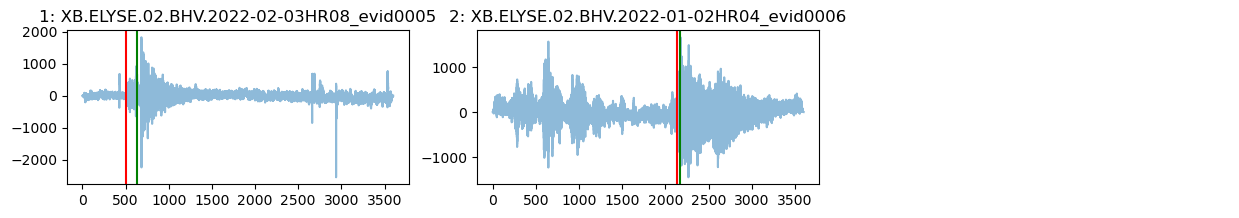

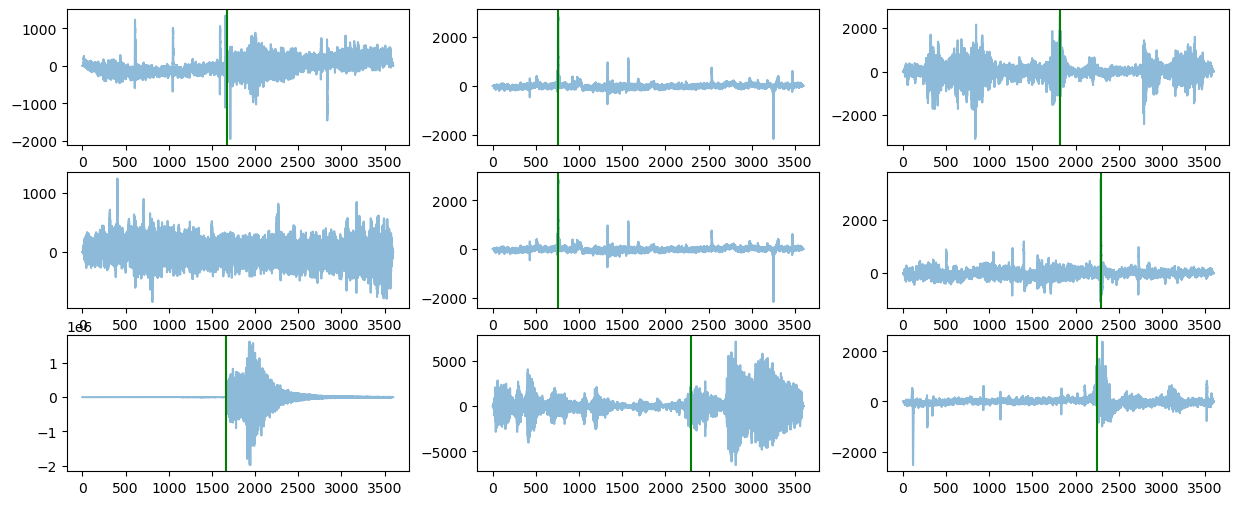

In [77]:
def show_predictions(yhat_train, yhat_test):
    nrows = (len(X_train) + 2) // 3
    fig, axs = plt.subplots(nrows, 3, figsize=(15, 2 * nrows))
    axs = axs.flatten()

    for i, stream in enumerate(X_train):
        x, y = stream[0].times(), stream[0].data

        axs[i].plot(x, y, alpha=0.5)
        axs[i].axvline(x=y_train[i], c="red")
        axs[i].axvline(x=yhat_train[i], c="green")
        axs[i].set_title(f"{i+1}: {train_filenames[i].stem}")
    for j in range(i + 1, len(axs)):
        axs[j].axis("off")

    plt.show()

    nrows = (len(X_test) + 2) // 3
    fig, axs = plt.subplots(nrows, 3, figsize=(15, 2 * nrows))
    axs = axs.flatten()

    for i, stream in enumerate(X_test):
        x, y = stream[0].times(), stream[0].data
        axs[i].plot(x, y, alpha=0.5)
        axs[i].axvline(x=yhat_test[i], c="green")
    plt.show()


show_predictions(yhat_train, yhat_test)